<a href="https://colab.research.google.com/github/Yeonseo-Jo/class2021Fall/blob/main/9.%20sound%20%EC%B6%94%EA%B0%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

* Sound 추가본

=> inensity, autocorrelation 부분 추가

### Phasor

In [2]:
# parameter setting
amp = 1          # range [0.0, 1.0]
sr = 10000       # sampling rate, Hz
dur = 0.5        # in seconds
freq = 100.0     # sine frequency, Hz
phase = np.pi/2  # phase, radian

In [3]:
# generate samples
nSamp = sr * dur
samples = np.arange(1, nSamp+1)

In [4]:
# convert samples to time
t = samples/sr

In [5]:
# convert time to angle in radian
theta0 = t * 2*np.pi * freq

In [6]:
# shift angle by phase
theta = theta0 + phase

In [7]:
# generate signal by sin-phasor
s = amp * np.sin(theta)

Text(0, 0.5, 'real')

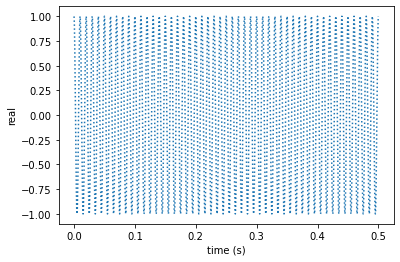

In [8]:
# plot the entire signal
plt.plot(t, s, ':')
plt.xlabel('time (s)')
plt.ylabel('real')

Text(0, 0.5, 'real')

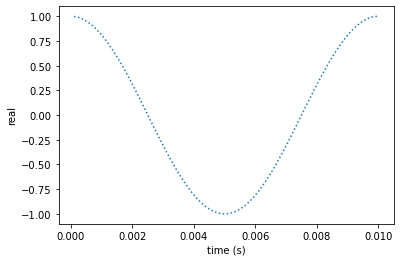

In [9]:
# plot a certain of signals
sampleRng = np.arange(0,100)
plt.plot(t[sampleRng], s[sampleRng], ':')
plt.xlabel('time (s)')
plt.ylabel('real')

In [10]:
ipd.Audio(s, rate=10000)

In [11]:
def phasor_sine(amp, sr, dur, freq, phase):
  t = np.arange(1, sr * dur+1)/sr
  theta = t * 2*np.pi * freq + phase
  s = amp * np.sin(theta)
  return s, t, theta

In [12]:
amp = 1; sr = 10000; dur = 1; freq = 440; phase = 0
s, t, theta = phasor_sine(amp, sr, dur, freq, phase)
ipd.Audio(s, rate=sr)

### Dividing signal by the window size and step

In [13]:
#amplitude를 windowing(조금씩 나누어서 amplitude가 작은지 큰지 계산)하여 sliding = 즉 framing을 해주는 function을 만드는 법
#즉, signal을 framing 해주는 function 만들기

def frame_signal(signal, srate, win_size, win_step):
    frame_size = int(win_size * srate)
    frame_step = int(win_step * srate)
#win_size = window(amplitude를 나눠 보는 부분, 하나의 사각형)의 크기 
#win_step = 얼마나 많이 옆으로 sliding 해 가는지



    # Get number of frames
    num_frames = int(np.ceil(np.abs(len(signal) - frame_size) / frame_step))
    # Pad signal
    pad_len = num_frames * frame_step + frame_size
    pad = np.zeros((pad_len - len(signal)))
    signal_padded = np.append(signal, pad)
    # Get within-frame sample indices
    idx1 = np.tile(np.arange(0, frame_size), (num_frames, 1))
    # Get vectors of frame_step increments
    idx2 = np.tile(np.arange(0, num_frames * frame_step, frame_step),
                   (frame_size, 1)).T
    # Get total indices divided by each frame
    indices = idx1 + idx2
    # Get frames divided by each frame based on indices
    frames = signal_padded[indices.astype(np.int32, copy=False)]
#     if cutoff is not None:
#         cutoff_bin = round(cutoff * nfft / (srate))  # hz -> bin
#         frames = frames[:, :cutoff_bin]
    return frames

### Load a wav file and frame signal

In [15]:
from scipy.io import wavfile
sr, s = wavfile.read('a.wav')   #a.wav라는 파일을 서버에 불러오기 해줘야됨

s = s/np.max(np.abs(s))     #np.max = 최댓값을 찾는다 / np.abs= 절댓값을 찾는다
#=>normalize하는 과정
t = np.arange(1, len(s)+1)/sr
#=> signal의 개수만큼 시간을 만드는 방법

win_size = 0.05
win_step = 0.05

#이를 통해 frames를 구할 수 있음
frames = frame_signal(s, sr, win_size, win_step)
framesT = np.arange(frames.shape[0]) * win_step + win_size/2  #win_size/2하는 이유는 window의 중간으로 시작을 나타내면 훨씬 더 편리하기 때문  (그래프를 편하게 보기 위해)
#framesT=>window 사각형들이 위치하는 시간 정보를 얻기 위함. (*win_step으로 시간 정보 얻음)
#이 시간은 window의 시작점을 뜻함 

ipd.Audio(s, rate=sr)

### Intensity by RMS

* RMS = Root mean square

=> amp.append(np.sqrt(np.mean(frame**2))) 이부분!

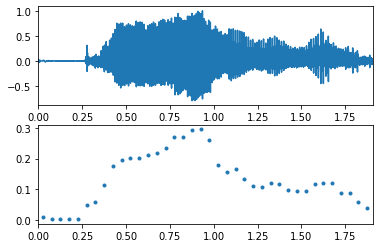

In [16]:
#intensity는 폭에 해당하는 부분

amp = []
for frame in frames:       #frames(앞에서 구한 값) = ndarray with shape(38,2205)
  amp.append(np.sqrt(np.mean(frame**2)))   #fram**2 = square => 모든 값들을 제곱하고 / np.mean으로 평균을 구하고 / np.sqrt로 루트를 씌움
  #frame이 0.05s로 쭉 쭉 가는 모양
  #loop를 돌고 나면 amp에 38개의 숫자가 할당됨

plt.plot(t, s)
plt.xlim([0, t[-1]])
plt.subplot(2,1,2)
plt.plot(framesT, amp, '.')
plt.xlim([0, t[-1]])
plt.show()

### Pitch by autocorrelation

In [ ]:
#pitch tracking(pitch의 값들 점 찍기)를 하기 위한 기법 = autocorrelation

def autocorr(s):
    result = np.correlate(s, s, mode='full')
    maxID = np.argmax(result)
    return result[maxID:]/result[maxID]

In [ ]:
F0 = []
for frame in frames:  #autocorrelation도 frame을 이용. (관심 있으면 읽어보기 내용 다루지 않음!)
  result = autocorr(frame)
  peakIdx = np.argmin(result) + np.argmax(result[np.argmin(result):])
  if result[peakIdx] >= 0.5:
    F0.append(1/(peakIdx/sr))
  else:
    F0.append(np.nan)

plt.subplot(2,1,1)
plt.plot(t, s)
plt.xlim([0, t[-1]])
plt.subplot(2,1,2)
plt.plot(framesT, F0, '.')
plt.xlim([0, t[-1]])
plt.show()

### Play musical notes

In [ ]:
def getFrequency(note):
    A4=440
    notes = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']

    octave = int(note[2]) if len(note) == 3 else int(note[1])
        
    keyNumber = notes.index(note[0:-1]);
    
    if (keyNumber < 3) :
        keyNumber = keyNumber + 12 + ((octave - 1) * 12) + 1; 
    else:
        keyNumber = keyNumber + ((octave - 1) * 12) + 1; 

    return A4 * 2** ((keyNumber- 49) / 12)

In [ ]:
amp = 1; sr = 10000; phase = 0

A4  = getFrequency('A4')
C5  = getFrequency('C5')
F5  = getFrequency('F5')
D5  = getFrequency('D5')
E5  = getFrequency('E5')	 
Eb5 = getFrequency('D#5') 
F5  = getFrequency('F5') 
G5  = getFrequency('G5')
Bb5 = getFrequency('A#5')
D6 = getFrequency('D6')

In [ ]:
# The bridge on the river Kwai

notes = [F5, D5, 0, D5, Eb5, F5, D6, 0, D6, 0, Bb5, 0, \
         F5, D5, 0, D5, Eb5, D5, F5, 0, F5, 0, Eb5, 0, \
         Eb5, C5, 0, C5, D5, Eb5, F5, D5, 0, D5, E5, D5, \
         C5, F5, D5, E5, C5, G5, F5]

durs = [0.25, 0.75, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, \
        0.25, 0.75, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, \
        0.25, 0.75, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.25, 0.25, \
        0.25, 0.5, 0.25, 0.25, 0.5, 0.25, 1.5]

In [ ]:
s_all = np.empty(0)

for note, dur in zip(notes, durs):
  s, t, th= phasor_sine(amp, sr, dur, note, phase)
  s_all = np.concatenate((s_all, s))

In [ ]:
ipd.Audio(s_all, rate=sr)